In [11]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 16 15:02:52 2020
Modified on Tue July 7 2020

@author: eburns3
@modified: dtak
"""


from astropy.io import fits
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import os

#from astropy_healpix import pixel_resolution_to_nside

#from pandas import DataFrame
import math
import numpy as np


#import glob

try:
    import healpy as hp
except ModuleNotFoundError:
    print('No Healpy, proceeding...\n')
    

import warnings

import warnings
warnings.filterwarnings("ignore")


def _validate_level(level):
    if np.any(level < 0):
        raise ValueError('level must be positive')
        

def level_to_nside(level):
    """
    Find the pixel dimensions of the top-level HEALPix tiles.

    This is given by ``nside = 2**level``.

    Parameters
    ----------
    level : int
        The resolution level

    Returns
    -------
    nside : int
        The number of pixels on the side of one of the 12 'top-level' HEALPix tiles.
    """
    level = np.asarray(level, dtype=np.int64)

    _validate_level(level)
    return 2 ** level


def pixel_resolution_to_nside(resolution, round='nearest'):
    """Find closest HEALPix nside for a given angular resolution.

    This function is the inverse of `nside_to_pixel_resolution`,
    for the default rounding scheme of ``round='nearest'``.

    If you choose ``round='up'``, you'll get HEALPix pixels that
    have at least the requested resolution (usually a bit better
    due to rounding).

    Pixel resolution is defined as square root of pixel area.

    Parameters
    ----------
    resolution : `~astropy.units.Quantity`
        Angular resolution
    round : {'up', 'nearest', 'down'}
        Which way to round

    Returns
    -------
    nside : int
        The number of pixels on the side of one of the 12 'top-level' HEALPix tiles.
        Always a power of 2.

    Examples
    --------
    >>> from astropy import units as u
    >>> from astropy_healpix import pixel_resolution_to_nside
    >>> pixel_resolution_to_nside(13 * u.arcmin)
    256
    >>> pixel_resolution_to_nside(13 * u.arcmin, round='up')
    512
    """
    resolution = resolution.to(u.rad).value
    pixel_area = resolution * resolution
    npix = 4 * math.pi / pixel_area
    nside = np.sqrt(npix / 12)

    # Now we have to round to the closest ``nside``
    # Since ``nside`` must be a power of two,
    # we first compute the corresponding ``level = log2(nside)`
    # round the level and then go back to nside
    level = np.log2(nside)

    if round == 'up':
        level = np.ceil(level)
    elif round == 'nearest':
        level = np.round(level)
    elif round == 'down':
        level = np.floor(level)
    else:
        raise ValueError(f'Invalid value for round: {round!r}')

    # For very low requested resolution (i.e. large angle values), we
    # return ``level=0``, i.e. ``nside=1``, i.e. the lowest resolution
    # that exists with HEALPix
    level = np.clip(level.astype(int), 0, None)

    return level_to_nside(level)


def temporal_check(new_Event_time, old_Event_times, offset_time=300.0):
    seconds_offset = np.abs((new_Event_time-old_Event_times).sec)
    filter_array = seconds_offset<offset_time
    return filter_array


def temporal_BF_check(new_Event_time, old_Event_times, priors = [1000.0, 30/365.25/86400, 99/365.25/86400, 236/365.25/86400] ):
    offset_time = priors[0]
    R_joint = priors[1]
    R_1 = priors[2]
    R_2 = priors[3]
    
    new_Event_time = Time(new_Event_time)
    old_Event_times = Time(old_Event_times)
    seconds_offset = np.abs((new_Event_time-old_Event_times).sec)
    if seconds_offset < offset_time:
        BF = R_joint/R_1/R_2/np.abs(offset_time)
    else:
        BF = 0
    return BF
    
def temporal_BFs_check(new_Event_times, old_Event_times, priors = [1000.0, 30/365.25/86400, 99/365.25/86400, 236/365.25/86400] ):
    offset_time = priors[0]
    R_joint = priors[1]
    R_1 = priors[2]
    R_2 = priors[3]
    
    new_Event_times = Time(new_Event_times)
    old_Event_times = Time(old_Event_times)

    BFs = np.zeros([len(new_Event_times), len(old_Event_times)])
    idt = np.identity(len(new_Event_times))
    
    seconds_offset = np.asarray([np.abs((new_Event_time-old_Event_times).sec) for new_Event_time in new_Event_times])
    
    filter_array = seconds_offset<offset_time
    BFs = [R_joint/R_1/R_2/np.abs(seconds_offset[i])*filter_array[i] for i in range(len(seconds_offset))]
    
    return BFs, filter_array, seconds_offset[0]

def make_circular_map(spatial_info, base_NSIDE):
    NPIX = hp.nside2npix(base_NSIDE)
    skymap = np.zeros(NPIX)
    center_pix = hp.pixelfunc.ang2pix(base_NSIDE, spatial_info[1], 
                                      spatial_info[2], lonlat=True)
    skymap[center_pix] = 1
    error_radius = spatial_info[3]
    error_equivalent_NSIDE = pixel_resolution_to_nside(error_radius*u.deg, round='up')

    if error_equivalent_NSIDE > base_NSIDE:
        skymap_smoothed = skymap
    else:
        skymap_smoothed = hp.smoothing(skymap, sigma=np.deg2rad(error_radius), 
                                   verbose=False)
    return skymap_smoothed


def make_uniform_map(base_NSIDE):
    npix = hp.pixelfunc.nside2npix(base_NSIDE)
    skymap = np.ones(npix)
    skymap = skymap/sum(skymap)
    return skymap


def get_HEALPix_map(spatial_info, base_NSIDE):    
#    if spatial_info[0] == 'Skymap-HEALPix':
#        skymap = hp.read_map(spatial_info[1], verbose=False)
#    elif spatial_info[0] == 'CIRCULAR':
#        skymap = make_circular_map(spatial_info, base_NSIDE)
    if spatial_info is None:
        skymap = make_uniform_map(base_NSIDE)
    elif os.path.isfile(spatial_info):
        skymap = hp.read_map(spatial_info, verbose=False)
    else:
        print(spatial_info)
    #add things like elliptical? IPN stuff? etc?
    return skymap


def get_skymaps(skymap_path_1, skymap_path_2, base_NSIDE=128):
#    print(skymap_path_1)
    skymap_1 = get_HEALPix_map(skymap_path_1, base_NSIDE)
#    skymap_1 = hp.read_map(skymap_path_1, verbose=False)
    skymap_2 = get_HEALPix_map(skymap_path_2, base_NSIDE)
#    skymap_2 = hp.read_map(skymap_path_2, verbose=False)
    max_NSIDE = max([hp.pixelfunc.get_nside(skymap_1), 
                     hp.pixelfunc.get_nside(skymap_2), base_NSIDE])
    
    if hp.pixelfunc.get_nside(skymap_1) < max_NSIDE:
        skymap_1 = hp.ud_grade(skymap_1, max_NSIDE)
    if hp.pixelfunc.get_nside(skymap_2) < max_NSIDE:
        skymap_2 = hp.ud_grade(skymap_2, max_NSIDE)
        
    skymap_1[skymap_1<0.0] = 0.0
    skymap_1 = skymap_1/sum(skymap_1)
    skymap_2[skymap_2<0.0] = 0.0
    skymap_2 = skymap_2/sum(skymap_2) 
    
    return skymap_1, skymap_2, max_NSIDE


def spatial_BF_check(skymap_1, skymap_2, max_NSIDE):

#    hp.mollview(skymap_1)
#    plt.savefig('skymap_1.png')
#    hp.mollview(skymap_2)
#    plt.savefig('skymap_2.png')
    
    A = 4*np.pi/hp.pixelfunc.nside2npix(max_NSIDE)
    if hp.pixelfunc.get_nside(skymap_1) != max_NSIDE:
        skymap_1 = hp.ud_grade(skymap_1, max_NSIDE)
    if hp.pixelfunc.get_nside(skymap_2) != max_NSIDE:
        skymap_2 = hp.ud_grade(skymap_2, max_NSIDE)
    
    
    skymap_1_p = skymap_1/A
    skymap_2_p = skymap_2/A
    
    I_Omega = 4*np.pi*np.sum(skymap_1_p*skymap_2_p)*A
    return I_Omega

In [5]:
import flask_backend
from flask_backend.models import db
app = flask_backend.create_app()
app.app_context().push()

In [6]:
from flask_backend.models import EventNotice, Event

In [ ]:
trig = [notice.trigger for notice in EventNotice.query.all()]

In [ ]:
id = [notice.mid for notice in EventNotice.query.all()]

In [ ]:
sum(np.asarray(id) == 5)

In [ ]:
len(trig)

In [ ]:
BFs, trig= temporal_BFs_check(trig)

In [7]:
nlist = [evt.notices for evt in Event.query.all() if len(evt.notices) > 1]

In [8]:
len(nlist)

27

In [9]:
nlist

[[<EventNotice (id: '154', mid: '1', tid: '743086', nid: '13430', evtid: '2152', event: 'GRB 170318B')>,
  <EventNotice (id: '2480', mid: '5', tid: '511543678', nid: '199845', evtid: '2152', event: 'GRB 170318B')>],
 [<EventNotice (id: '45', mid: '1', tid: '745797', nid: '3499', evtid: '2160', event: 'GRB 170405A')>,
  <EventNotice (id: '2215', mid: '5', tid: '513110367', nid: '194705', evtid: '2160', event: 'GRB 170405A')>],
 [<EventNotice (id: '183', mid: '1', tid: '748947', nid: '15647', evtid: '2164', event: 'GRB 170419B')>,
  <EventNotice (id: '2223', mid: '5', tid: '514330431', nid: '195203', evtid: '2164', event: 'GRB 170419B')>],
 [<EventNotice (id: '92', mid: '1', tid: '756284', nid: '8059', evtid: '2182', event: 'GRB 170607A')>,
  <EventNotice (id: '2184', mid: '5', tid: '518570284', nid: '192472', evtid: '2182', event: 'GRB 170607A')>],
 [<EventNotice (id: '142', mid: '1', tid: '760064', nid: '12472', evtid: '2188', event: 'GRB 170705A')>,
  <EventNotice (id: '2015', mid: '5

In [12]:
tdiff = []
for notices in nlist:
    tdiff.append([abs(Time(notices[0].trigger)-Time(notices[1].trigger)).sec, notices[0].event])
tdiff = np.asarray(tdiff)

In [19]:
tdiff

array([['0.5399999999987415', 'GRB 170318B'],
       ['25.53999999998986', 'GRB 170405A'],
       ['0.7599999999953866', 'GRB 170419B'],
       ['214.1399999999976', 'GRB 170607A'],
       ['3.949999999994702', 'GRB 170705A'],
       ['0.0800000000005241', 'GRB 170711A'],
       ['0.05999999999559691', 'GRB 170803A'],
       ['7.680000000011944', 'GRB 170813A'],
       ['0.5799999999990035', 'GRB 170903A'],
       ['3.4700000000107423', 'GRB 170906A'],
       ['4.880000000003193', 'GRB 170906B'],
       ['0.18999999999884665', 'GRB 170912B'],
       ['1.629999999998688', 'GRB 171007A'],
       ['2.919999999999945', 'GRB 180102A'],
       ['0.5200000000034066', 'GRB 180113A'],
       ['11.47999999999847', 'GRB 180314A'],
       ['0.10000000000545128', 'GRB 180402A'],
       ['28.559999999995256', 'GRB 180410A'],
       ['0.03999999999066972', 'GRB 180418A'],
       ['2.610000000000312', 'GRB 180630A'],
       ['0.05999999999559691', 'GRB 180715A'],
       ['4.93999999999879', 'GRB 18072

Text(0.5, 0, 'abs( trigger time difference )')

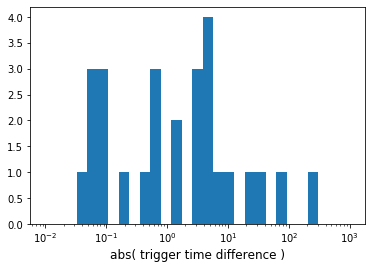

In [17]:
plt.hist(tdiff[:,0].astype("float"), bins=np.logspace(-2, 3, 30))
plt.xscale("log")
plt.xlabel("abs( trigger time difference )", fontsize=12)

$$BF = \frac{R_{joint}}{R_1 R_2 |t_1 - t_2|}$$

$$R_{joint} = \frac{30}{365.25 \times 86400}$$

$$R_{Fermi} = \frac{236}{365.25 \times 86400}$$

$$R_{Swift} = \frac{99}{365.25 \times 86400}$$

In [29]:
R_joint/R_1/R_2/1000

40.52080123266563

Text(0.5, 0, 'BF')

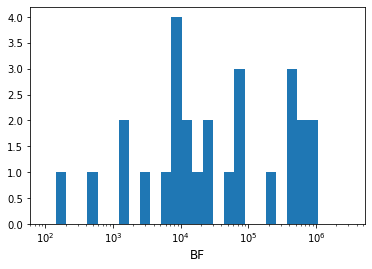

In [27]:
priors = [1000.0, 30/365.25/86400, 99/365.25/86400, 236/365.25/86400]
offset_time = priors[0]
R_joint = priors[1]
R_1 = priors[2]
R_2 = priors[3]

plt.hist(R_joint/R_1/R_2/tdiff[:,0].astype("float"), bins=np.logspace(2, 6.5, 30))
plt.xscale("log")
plt.xlabel("BF", fontsize=12)

In [18]:
max(tdiff[:,0].astype())

'81.3100000000123'